In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances, euclidean_distances

import torch.nn as nn
from torch_geometric.nn.conv import *
from torch.optim import Adam
import torch

torch.set_default_dtype(torch.float64)

In [2]:
phi = (1 + np.sqrt(5)) / 2
icosahedron = []

for k in range(3):
    
    for i in range(2):
        for j in range(2):
            if k == 0:
                t = (0, (-1)**j, phi * (-1)**i)
                icosahedron.append(t)

            elif k == 1:
                t = ((-1)**j, phi * (-1)**i, 0)
                icosahedron.append(t)

            elif k == 2:
                t = (phi * (-1)**i, 0, (-1)**j)
                icosahedron.append(t)

icosahedron = np.stack(icosahedron)
icosahedron /= np.linalg.norm(icosahedron, axis = 1)[0]

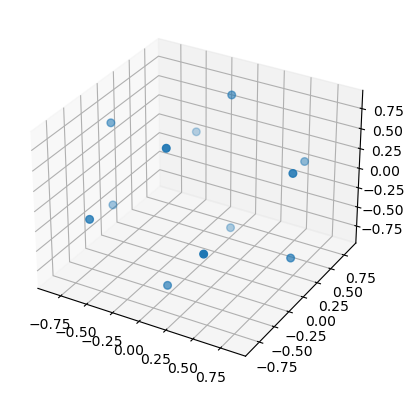

In [3]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(icosahedron[:,0], icosahedron[:,1], icosahedron[:,2], s = 30)

In [4]:
edges = np.nonzero((pairwise_distances(icosahedron) < 1.06)) # & (pairwise_distances(icosahedron) > 0.06)

In [5]:
level1 = 0.5 * icosahedron[edges[0]] + 0.5 * icosahedron[edges[1]]
level1 /= np.linalg.norm(level1, axis = 1).reshape(-1, 1)
level1 = np.unique(level1, axis = 0) 

In [6]:
level1.shape

(42, 3)

In [7]:
edges2 = np.nonzero(pairwise_distances(level1) < 0.7)

level2 = 0.5 * level1[edges2[0]] + 0.5 * level1[edges2[1]]
level2 /= np.linalg.norm(level2, axis = 1).reshape(-1, 1)
level2 = np.unique(level2, axis = 0)

In [8]:
level2.shape

(162, 3)

In [9]:
edges3 = np.nonzero(pairwise_distances(level2) < 0.325)

level3 = 0.5 * level2[edges3[0]] + 0.5 * level2[edges3[1]]
level3 /= np.linalg.norm(level3, axis = 1).reshape(-1, 1)
level3 = np.unique(level3, axis = 0)

In [10]:
level3.shape

(642, 3)

In [11]:
edges4 = np.nonzero(pairwise_distances(level3) < 0.2)

level4 = 0.5 * level3[edges4[0]] + 0.5 * level3[edges4[1]]
level4 /= np.linalg.norm(level4, axis = 1).reshape(-1, 1)
level4 = np.unique(level4, axis = 0)

level4.shape

(2562, 3)

## at this point we begin with 1-dimensional input data

In [12]:
A4 = torch.tensor(np.stack(np.nonzero(pairwise_distances(level4) < 0.09)))
A3 = torch.tensor(np.stack(np.nonzero(pairwise_distances(level3) < 0.22)))
A2 = torch.tensor(np.stack(np.nonzero(pairwise_distances(level2) < 0.45)))
A1 = torch.tensor(np.stack(np.nonzero(pairwise_distances(level1) < 0.97)))


In [68]:
A4_3 = np.exp(-1 * (euclidean_distances(level4, level3) / 0.09)**2)
P4_3 = torch.tensor(A4_3 / A4_3.sum(axis = 1).reshape(-1, 1))

A3_2 = np.exp(-1 * (euclidean_distances(level3, level2) / 0.22)**2)
P3_2 = torch.tensor(A3_2 / A3_2.sum(axis = 1).reshape(-1, 1))

A2_1 = np.exp(-1 * (euclidean_distances(level2, level1) / 0.45)**2)
P2_1 = torch.tensor(A2_1 / A2_1.sum(axis = 1).reshape(-1, 1))

A1_2 = np.exp(-1 * (euclidean_distances(level1, level2) / 0.45)**2)
P1_2 = torch.tensor(A1_2 / A1_2.sum(axis = 1).reshape(-1, 1))

A2_3 = np.exp(-1 * (euclidean_distances(level2, level3) / 0.22)**2)
P2_3 = torch.tensor(A2_3 / A2_3.sum(axis = 1).reshape(-1, 1))

A3_4 = np.exp(-1 * (euclidean_distances(level3, level4) / 0.09)**2)
P3_4 = torch.tensor(A3_4 / A3_4.sum(axis = 1).reshape(-1, 1))

In [31]:
class Encoder(nn.Module):
    def __init__(self, hidden_size = 16):
        super().__init__()

        self.enc1a = GCNConv(1, hidden_size)
        self.enc1b = GCNConv(hidden_size, hidden_size)
        self.enc1c = GCNConv(1, hidden_size)

        self.enc2a = GCNConv(hidden_size, hidden_size)
        self.enc2b = GCNConv(hidden_size, hidden_size)

        self.enc3a = GCNConv(hidden_size, hidden_size)
        self.enc3b = GCNConv(hidden_size, hidden_size)

        self.enc4a = GCNConv(hidden_size, hidden_size)
        self.enc4b = GCNConv(hidden_size, hidden_size)

        self.act = nn.ReLU()

    def forward(self, x): # here we let x just be the data at the points already

        # first block down
        x1 = self.enc1a(x, edge_index = A4)
        x1 = self.act(x1)
        x1 = self.enc1b(x1, edge_index = A4)

        x = self.enc1c(x, edge_index = A4)
        x = self.act(x + x1)

        x = P4_3.T @ x

        # second block down
        x1 = self.enc2a(x, edge_index = A3)
        x1 = self.act(x1)
        x1 = self.enc2b(x, edge_index = A3)

        x = self.act(x + x1)

        x = P3_2.T @ x

        # third block down
        x1 = self.enc3a(x, edge_index = A2)
        x1 = self.act(x1)
        x1 = self.enc3b(x, edge_index = A2)

        x = self.act(x + x1)

        x = P2_1.T @ x

        # final block
        x1 = self.enc3a(x, edge_index = A1)
        x1 = self.act(x1)
        x1 = self.enc3b(x, edge_index = A1)
        
        return x + x1

In [71]:
class Decoder(nn.Module):
    def __init__(self, hidden_size = 16):
        super().__init__()

        self.dec1a = GCNConv(hidden_size, hidden_size)
        self.dec1b = GCNConv(hidden_size, hidden_size)

        self.dec2a = GCNConv(hidden_size, hidden_size)
        self.dec2b = GCNConv(hidden_size, hidden_size)

        self.dec3a = GCNConv(hidden_size, hidden_size)
        self.dec3b = GCNConv(hidden_size, hidden_size)

        self.dec4a = GCNConv(hidden_size, hidden_size)
        self.dec4b = GCNConv(hidden_size, 1)
        self.dec4c = GCNConv(hidden_size, 1)

        self.act = nn.ReLU()

    def forward(self, z, eps):

        z = torch.cat([z, eps], dim = 1)

        # first block
        z1 = self.dec1a(z, edge_index = A1)
        z1 = self.act(z1)
        z1 = self.dec1b(z1, edge_index = A1)

        z = self.act(z + z1)

        z = P1_2.T @ z

        # second block
        z1 = self.dec2a(z, edge_index = A2)
        z1 = self.act(z1)
        z1 = self.dec2b(z1, edge_index = A2)

        z = self.act(z + z1)

        z = P2_3.T @ z

        # third block
        z1 = self.dec3a(z, edge_index = A3)
        z1 = self.act(z1)
        z1 = self.dec3b(z1, edge_index = A3)

        z = self.act(z + z1)

        z = P3_4.T @ z

        # last block (no activation)
        z1 = self.dec4a(z, edge_index = A4)
        z1 = self.act(z1)
        z1 = self.dec4b(z1, edge_index = A4)

        z = self.dec4c(z, edge_index = A4)
        
        return z + z1

In [72]:
x = torch.randn(2562, 1)

encoder = Encoder()
z = encoder(x)

K = 16
k = 10

zinput = z[:,0:k]
epsinput = torch.randn(42, K)[:,k:K]

decoder = Decoder()
x_hat = decoder(zinput, epsinput)
epsinput.shape, zinput.shape, x_hat.shape

(torch.Size([42, 6]), torch.Size([42, 10]), torch.Size([2562, 1]))

In [76]:
class DPAGraph(nn.Module):
    def __init__(self, hidden_size = 16):
        super().__init__()
        self.encoder = Encoder(hidden_size = hidden_size)
        self.decoder = Decoder(hidden_size = hidden_size)

        self.hidden_size = hidden_size

    def forward(self, x, k):
        z = self.encoder(x)

        zinput = z[:,0:k]
        epsinput1 = torch.randn(42, K)[:,k:self.hidden_size] # 42 is the lowest graph size için
        epsinput2 = torch.randn(42, K)[:,k:self.hidden_size]

        x_hat1 = decoder(zinput, epsinput1)
        x_hat2 = decoder(zinput, epsinput2)

        return x_hat1, x_hat2
        

In [77]:
dpa = DPAGraph()
dpa(x, 10)

(tensor([[-0.1671],
         [-0.1704],
         [-0.1721],
         ...,
         [-0.1859],
         [-0.1806],
         [-0.1788]], grad_fn=<AddBackward0>),
 tensor([[-0.1607],
         [-0.1647],
         [-0.1648],
         ...,
         [-0.1925],
         [-0.1878],
         [-0.1854]], grad_fn=<AddBackward0>))

In [ ]:
# do training loop here now :)